In [1]:
import pandas as pd
import base64
import numpy as np
from scipy import stats
import itertools as it
import random
#from project.folder.constants import *

In [2]:
df5 = pd.read_parquet('~/cloudfiles/code/users/arinjay.jain1/datasets/hackathon_dataset_decoded_mode.parquet')
df5.head(4)

,Episode,Label,decoded_signal
0,DeviceOSEBCMPDZAZ7__EpisodeHFDMGC46COM2,0,"[70.0, -56.0, -97.0, -109.0, -55.0, 29.0, 59.0..."
1,Device/KDFTQ4HUMRD__EpisodeW5+1+HZDWVQE,1,"[8.0, 9.0, 9.0, 7.0, 7.0, 6.0, 13.0, 14.0, 10...."
2,DeviceDLFOL6DT/WOV__EpisodeUYPCWAWAZYGZ,0,"[-4.0, -2.0, -1.0, 0.0, 1.0, 3.0, 3.0, 1.0, 0...."
3,DeviceQEMR3QU3IMXF__EpisodeXF8CO+KDN0TN,0,"[6.0, 7.0, 8.0, 7.0, 5.0, 6.0, 6.0, 6.0, 6.0, ..."


In [3]:
df5_lable_1 = df5[df5['Label'] == 1]
df= df5.append([df5_lable_1]*1,ignore_index=True)

In [4]:
df.Label.value_counts()

0    18388
1    18060
Name: Label, dtype: int64

In [5]:
#CNN
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout, BatchNormalization

#splitting dataset to dependent and independent variable
X = df['decoded_signal'].values #independent values / features
y = df['Label'].values #dependent values / target

#splitting the datasets for training and testing process
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

X_train = np.vstack(X_train).astype(np.float)
y_train = np.vstack(y_train).astype(np.float)
X_test = np.vstack(X_test).astype(np.float)
y_test = np.vstack(y_test).astype(np.float)


#size for the sets
print('size of X_train:', X_train.shape)
print('size of X_test:', X_test.shape)
print('size of y_train:', y_train.shape)
print('size of y_test:', y_test.shape)



#Reshape train and test data to (n_samples, 19184, 1), where each sample is of size (19184, 1)
X_train = np.array(X_train).reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

print("X Train shape: ", X_train.shape)
print("X Test shape: ", X_test.shape)

size of X_train: (29158, 19184)
size of X_test: (7290, 19184)
size of y_train: (29158, 1)
size of y_test: (7290, 1)
X Train shape:  (29158, 19184, 1)
X Test shape:  (7290, 19184, 1)


In [6]:
# Create sequential model 
import tensorflow as tf
cnn_model = tf.keras.models.Sequential()
#First CNN layer  with 32 filters, conv window 3, relu activation and same padding
cnn_model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.0008), input_shape = (19184,1)))
cnn_model.add(BatchNormalization())

#Second CNN layer  with 64 filters, conv window 3, relu activation and same padding
cnn_model.add(Conv1D(filters=64, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.0008)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

#Third CNN layer with 128 filters, conv window 3, relu activation and same padding
cnn_model.add(Conv1D(filters=128, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.0008)))
cnn_model.add(BatchNormalization())

#Fourth CNN layer with Max pooling
cnn_model.add(MaxPool1D(pool_size=(3,), strides=2, padding='same'))
cnn_model.add(Dropout(0.5))

#Flatten the output
cnn_model.add(Flatten())

#Add a dense layer with 256 neurons
cnn_model.add(Dense(units = 256, activation=tf.keras.layers.LeakyReLU(alpha=0.0008)))

#Add a dense layer with 512 neurons
cnn_model.add(Dense(units = 512, activation=tf.keras.layers.LeakyReLU(alpha=0.0008)))

#sigmoid as last layer with 1 outputs
cnn_model.add(Dense(units = 1, activation='sigmoid'))

In [7]:
from tensorflow.keras import backend as K

def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [8]:
cnn_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy', recall, precision, get_f1])

In [9]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 19184, 32)         128       
_________________________________________________________________
batch_normalization (BatchNo (None, 19184, 32)         128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19184, 64)         6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 19184, 64)         256       
_________________________________________________________________
dropout (Dropout)            (None, 19184, 64)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19184, 128)        24704     
_________________________________________________________________
batch_normalization_2 (Batch (None, 19184, 128)        5

In [10]:

cnn_model_history = cnn_model.fit(X_train, y_train, epochs=50, batch_size = 100, validation_data = (X_test, y_test))

Epoch 1/50
108/292 [==========>...................] - ETA: 8:34 - loss: 11.3085 - accuracy: 0.5486 - recall: 0.5666 - precision: 0.5263 - get_f1: 0.4920

Text(0, 0.5, 'Accuracy')

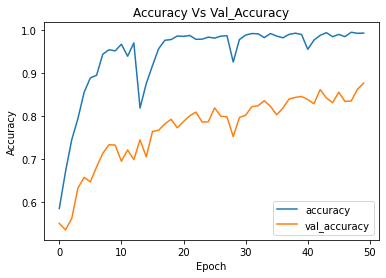

In [16]:
import matplotlib.pyplot as plt
plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.title('Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

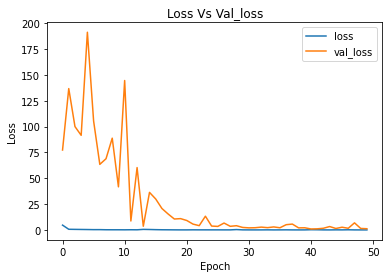

In [22]:
plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.title('Loss Vs Val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [37]:
cnn_model.predict(np.array(X_train[3625]).reshape(1, 19184, 1))

array([[6.886134e-08]], dtype=float32)

In [40]:
cnn_model.predict(np.array(X_test).reshape(1, 19184, 1))

array([[1.0000000e+00],
       [9.9982685e-01],
       [2.8003790e-11],
       ...,
       [0.0000000e+00],
       [9.3420917e-01],
       [7.7022610e-14]], dtype=float32)

In [45]:
cnn_model.save('cnn_model_v3')

In [44]:
from tensorflow import keras
model_cnn_v = keras.models.load_model('cnn_model_v3', custom_objects={'recall':recall, 'precision':precision, 'get_f1':get_f1}, compile=False)

In [54]:
if model_cnn_v.predict(np.array(X_test[265]).reshape(1, 19184, 1))>0.5:
    print(1)
else:
    print(0)

0


In [56]:
model_cnn_v_try = keras.models.load_model('CNN_model_v2.h5', custom_objects={'recall':recall, 'precision':precision, 'get_f1':get_f1}, compile=False)

AttributeError: 'str' object has no attribute 'decode'

In [57]:
!pip install keras2onnx

In [58]:
# convert to onnx model
import keras2onnx
onnx_model = keras2onnx.convert_keras(model_cnn_v, model.name)

Using TensorFlow backend.


AttributeError: module 'tensorflow.compat.v2' has no attribute '__internal__'

In [2]:
import tensorflow as tf
import onnx
from tensorflow.keras import keras2onnx

ImportError: cannot import name 'keras2onnx' from 'tensorflow.keras' (/anaconda/envs/azureml_py38/lib/python3.8/site-packages/tensorflow/keras/__init__.py)

In [3]:
model = tf.keras.models.load_model('CNN_model_v2.h5')

ValueError: Unknown activation: LeakyReLU

In [7]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [8]:
df_2 = pd.read_parquet('~/cloudfiles/code/users/arinjay.jain1/datasets/hackathon_dataset_decoded_mode.parquet')
df_2.head(5)

,Episode,Label,decoded_signal
0,DeviceOSEBCMPDZAZ7__EpisodeHFDMGC46COM2,0,"[70.0, -56.0, -97.0, -109.0, -55.0, 29.0, 59.0..."
1,Device/KDFTQ4HUMRD__EpisodeW5+1+HZDWVQE,1,"[8.0, 9.0, 9.0, 7.0, 7.0, 6.0, 13.0, 14.0, 10...."
2,DeviceDLFOL6DT/WOV__EpisodeUYPCWAWAZYGZ,0,"[-4.0, -2.0, -1.0, 0.0, 1.0, 3.0, 3.0, 1.0, 0...."
3,DeviceQEMR3QU3IMXF__EpisodeXF8CO+KDN0TN,0,"[6.0, 7.0, 8.0, 7.0, 5.0, 6.0, 6.0, 6.0, 6.0, ..."
4,DeviceXLBY/IIVTCUE__EpisodeUOW1CTCRGD5M,0,"[-4.0, -4.0, -3.0, -4.0, -4.0, -4.0, -4.0, -3...."


In [9]:
from grpc import local_server_credentials
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from numpy import trapz
import base64
import pickle
import tempfile # Required import, do not remove
# import onnxruntime as nxrun
import neurokit2 as nk
from sklearn.metrics import f1_score
def align_fft(sigs_parsed,nbin=128):
        N=4*60*128
        s_new=[]

        for s in (sigs_parsed):
                if(len(s))>=N:
                        s_new.append(list(s[:N]))
                else:
                        z=N-len(s)
                        lst = [0] * z
                        c=np.hstack([s,lst])
                        s_new.append(c)      
        sr =  1/128
        T=N/sr
        n=np.arange(N)
        freq=n/T
        
        n_one_size=int(N/2)
        f_oneside=freq[:n_one_size]

        pe=int(N/nbin/2)
       
        for i, sig in enumerate(s_new):
            
            s_new[i]=np.abs(fft(sig)[:n_one_size])
            s_new[i]= s_new[i].reshape(-1,pe).mean(1)        
        #     xmax= max(s_new[i])
        #     xmin= min(s_new[i])
        #     s_new[i]=(s_new[i]-xmin)/(xmax-xmin)

            

        return s_new
def classify(signal: np.ndarray) -> int:
    assert type(signal) == np.ndarray, 'signal should be np.ndarray'
    peaks, _ = nk.ecg_peaks(signal, sampling_rate=120)
    hrv_time = nk.hrv_time(peaks, sampling_rate=120)
    hrv_freq = nk.hrv_frequency(peaks, sampling_rate=120, normalize=True)
    frame2=[hrv_time,hrv_freq]
    df_o=pd.concat(frame2,axis=1)
    t=nk.ecg_quality(signal, method="zhao2018",sampling_rate=128)
    if(t=='Unacceptable'):
        df_o['quality'] = 0
    else:
        df_o['quality'] = 1
    df_o.drop(columns=['HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF'],inplace=True)
    df_o= df_o.fillna(0)
    nk_feature=list(df_o.values[0])
    local=[]
    local.append(signal)
#     local=parse_signal(local)
    fft_feature=align_fft(local,nbin=256)    
    c=np.hstack([fft_feature[0],nk_feature])
    local=[]
    local.append(c)
    #res=model.predict(local)[0]
    return local

In [10]:
df_2['new_signal'] = df_2['decoded_signal'].apply(classify)

In [11]:
df_2

,Episode,Label,decoded_signal,new_signal
0,DeviceOSEBCMPDZAZ7__EpisodeHFDMGC46COM2,0,"[70.0, -56.0, -97.0, -109.0, -55.0, 29.0, 59.0...","[[1869.8386173835156, 1216.6577899963092, 969...."
1,Device/KDFTQ4HUMRD__EpisodeW5+1+HZDWVQE,1,"[8.0, 9.0, 9.0, 7.0, 7.0, 6.0, 13.0, 14.0, 10....","[[2214.8873601300456, 3127.858671714706, 2490...."
2,DeviceDLFOL6DT/WOV__EpisodeUYPCWAWAZYGZ,0,"[-4.0, -2.0, -1.0, 0.0, 1.0, 3.0, 3.0, 1.0, 0....","[[994.5445876290639, 1693.62505950252, 932.793..."
3,DeviceQEMR3QU3IMXF__EpisodeXF8CO+KDN0TN,0,"[6.0, 7.0, 8.0, 7.0, 5.0, 6.0, 6.0, 6.0, 6.0, ...","[[1212.161953349213, 1623.170260800203, 1284.2..."
4,DeviceXLBY/IIVTCUE__EpisodeUOW1CTCRGD5M,0,"[-4.0, -4.0, -3.0, -4.0, -4.0, -4.0, -4.0, -3....","[[848.4253403484178, 1717.0549162936684, 1705...."
...,...,...,...,...
27413,DeviceH09PHB8GSTGK__EpisodeRD60JRL5WKZB,1,"[7.0, 7.0, 6.0, 6.0, 7.0, 6.0, 6.0, 5.0, 5.0, ...","[[1194.6971494984148, 1322.2063441084285, 2425..."
27414,DeviceAMJQPZYJ3MZD__Episode4JTSSSQSUXS1,0,"[-1.0, -3.0, -5.0, -6.0, -6.0, -6.0, -6.0, -6....","[[1795.9657216900355, 1493.5492756369958, 656...."
27415,DeviceYWKHBNNHO2WN__EpisodeNQQ4OG12I+QW,1,"[-1.0, -2.0, -1.0, -1.0, 0.0, 1.0, 1.0, 5.0, 1...","[[1676.744596072007, 2069.499395834926, 1860.1..."
27416,Device7C0VTWXNEWBJ__EpisodeAY/S6NCLKPIK,0,"[-51.0, -77.0, -32.0, 15.0, 13.0, 2.0, 4.0, 8....","[[1386.9612108494666, 949.9086032967457, 972.9..."


In [12]:
df_2[['new_signal', 'Label']].to_parquet('~/cloudfiles/code/users/arinjay.jain1/datasets/hackathon_dataset_new_signal_2.parquet')